In [1]:
import pandas as pd
import os

%matplotlib inline 
#so that the plot will be displayed in the notebook
import matplotlib.pyplot as plt

def load_data(housing_path):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [2]:
housing = load_data("housing/")

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
import numpy as np
np.random.seed(42)

16512 training instances + 4128 test instances


In [5]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), "training instances +", len(test_set), "test instances")

16512 training instances + 4128 test instances


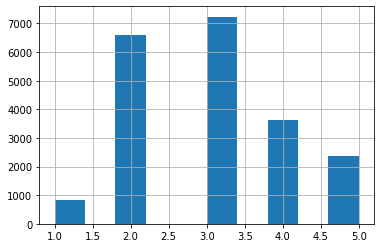

In [6]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace = True)

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [8]:
# housing = strat_train_set.drop("median_house_value", axis=1) # inplace=False
# housing_labels = strat_train_set["median_house_value"].copy()

In [9]:
# def add_features(data):
#     # add the transformed features that you found useful before
#     data["rooms_per_household"] = data["total_rooms"] / data["households"]
#     data["bedrooms_per_household"] = data["total_bedrooms"] / data["households"]
#     data["bedrooms_per_rooms"] = data["total_bedrooms"] / data["total_rooms"]
#     data["population_per_household"] = data["population"] / data["households"]
    
# add_features(housing)

In [10]:
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(strategy="mean")
housing_num = housing.drop("ocean_proximity", axis=1)
# imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [11]:
# X = imputer.transform(housing_num)
# housing_tr = pd.DataFrame(X, columns=housing_num.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 13 columns):
longitude                   16512 non-null float64
latitude                    16512 non-null float64
housing_median_age          16512 non-null float64
total_rooms                 16512 non-null float64
total_bedrooms              16512 non-null float64
population                  16512 non-null float64
households                  16512 non-null float64
median_income               16512 non-null float64
income_cat                  16512 non-null float64
rooms_per_household         16512 non-null float64
bedrooms_per_household      16512 non-null float64
bedrooms_per_rooms          16512 non-null float64
population_per_household    16512 non-null float64
dtypes: float64(13)
memory usage: 1.6 MB


In [14]:
from sklearn.base import TransformerMixin # TransformerMixin allows you to use fit_transform method

class CustomLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, X, y=0):
        self.encoder.fit(X)
        return self
    def transform(self, X, y=0):
        return self.encoder.transform(X)

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin 
# BaseEstimator allows you to drop *args and **kwargs from you constructor
# and, in addition, allows you to use methods set_params() and get_params()

rooms_id, bedrooms_id, population_id, household_id = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_rooms = True): # note no *args and **kwargs used this time
        self.add_bedrooms_per_rooms = add_bedrooms_per_rooms
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_id] / X[:, household_id]
        bedrooms_per_household = X[:, bedrooms_id] / X[:, household_id]
        population_per_household = X[:, population_id] / X[:, household_id]
        if self.add_bedrooms_per_rooms:
            bedrooms_per_rooms = X[:, bedrooms_id] / X[:, rooms_id]
            return np.c_[X, rooms_per_household, bedrooms_per_household, 
                         population_per_household, bedrooms_per_rooms]
        else:
            return np.c_[X, rooms_per_household, bedrooms_per_household, 
                         population_per_household]
        
attr_adder = CombinedAttributesAdder()

array([[-121.89, 37.29, 38.0, ..., 1.0353982300884956, 2.094395280235988,
        0.22385204081632654],
       [-121.93, 37.05, 14.0, ..., 0.9557522123893806,
        2.7079646017699117, 0.15905743740795286],
       [-117.2, 32.77, 31.0, ..., 1.0194805194805194, 2.0259740259740258,
        0.24129098360655737],
       ...,
       [-116.4, 34.09, 9.0, ..., 1.1398692810457516, 2.742483660130719,
        0.1796086508753862],
       [-118.01, 33.82, 31.0, ..., 1.0674157303370786, 3.808988764044944,
        0.19387755102040816],
       [-122.45, 37.77, 52.0, ..., 1.0672926447574336,
        1.9859154929577465, 0.22035541195476574]], dtype=object)

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

In [18]:
from sklearn.pipeline import Pipeline

# num_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy="mean")),
#     ('std_scaler', StandardScaler()),
# ])

# housing_num_tr = num_pipeline.fit_transform(housing_num)
# housing_num_tr.shape

(16512, 13)

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [20]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="mean")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', CustomLabelBinarizer()),
    ])

In [21]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared.shape)
housing_prepared

KeyError: "['bedrooms_per_household', 'rooms_per_household', 'population_per_household', 'bedrooms_per_rooms'] not in index"

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression())])

model = model.fit(housing_prepared, housing_labels)
housing_predictions = model.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg = tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_mse = np.sqrt(tree_mse)
tree_mse

In [ ]:
from sklearn.model_selection import cross_val_score
    
def analyse_cv(model):   
    scores = cross_val_score(model, housing_prepared, housing_labels,
                             scoring = "neg_mean_squared_error", cv=10)

    # cross-validation expects utility function (greater is better)
    # rather than cost function (lower is better), so the scores returned
    # are negative as they are the opposite of MSE
    sqrt_scores = np.sqrt(-scores) 
    print("Scores:", sqrt_scores)
    print("Mean:", sqrt_scores.mean())
    print("Standard deviation:", sqrt_scores.std())
    
analyse_cv(tree_reg)

In [ ]:
analyse_cv(lin_reg)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10)
analyse_cv(forest_reg)

In [ ]:
from sklearn.model_selection import GridSearchCV

# specify the range of hyperparameter values for the grid search to try out 
param_grid = {'n_estimators': [3, 10, 30, 50], 'max_features': [2, 4, 6, 8]}

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_

In [ ]:
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
extra_attribs = ['rooms_per_household', 'bedrooms_per_household', 'population_per_household', 'bedrooms_per_rooms']
cat_one_hot_attribs = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

# Assignments

**For the tick session**:

## 1. 
Familiarise yourself with the code in this practical. During the tick session, be prepared to discuss the different steps and answer questions (as well as ask questions yourself).

## 2.
Experiment with the different steps in the ML pipeline:
- try dropping less informative features from the feature set and test whether it improves performance
- use other options in preprocessing: e.g., different imputer strategies, min-max rather than standardisation for scaling, feature scaling vs. no feature scaling, and compare the results
- evaluate the performance of the simple linear regression model on the test set. What is the `final_rmse` for this model?
- estimate different feature importance weights with the simple linear regression model (if unsure how to extract the feature weights, check [documentation](http://scikit-learn.org/stable/modules/linear_model.html)). How do these compare to the (1) feature importance weights with the best estimator, and (2) feature correlation scores with the target value from Step 3?
- [`RandomizedSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), as opposed to the `GridSearchCV` used in the practical, does not try out each parameter values combination. Instead it only tries a fixed number of parameter settings sampled from the specified distributions. As a result, it allows you to try out a wider range of parameter values in a less expensive way than `GridSearchCV`. Apply `RandomizedSearchCV` and compare the best estimator results.

Finally, if you want to have more practice with regression tasks, you can **work on the following optional task**:

## 3. (Optional)

Use the bike sharing dataset (`./bike_sharing/bike_hour.csv`, check `./bike_sharing/Readme.txt` for the description), apply the ML steps and gain insights from the data. What data transformations should be applied? Which attributes are most predictive? What additional attributes can be introduced? Which regression model performs best?